# Neural SDE (VAE)

This implementation is based on Pytorch version of Latent SDE from [`torchsde`](https://github.com/google-research/torchsde/blob/master/examples/latent_sde.py) library. 

The training follows Bayesian inference procedure where we assume the prior of a SDE having a simple drift function (`drift_prior`).

The posterior is approximated by a neural SDE with a more complex drift function (`drift_posterior`). Note that both prior and posterior share a same diffusion.

The objective function is computed via evidence lower bound (ELBO) which requires to get Kullback-Leibler (KL) divergence between prior and the approximated posterior.

The KL divergence turns out to be a result of Girsanov's theorem. The function `diffrax.misc.sde_kl_divergence` allow us to augment the original SDE with KL estimation.

This notebook for this example can be found [here](https://github.com/patrick-kidger/diffrax/blob/main/examples/neural_sde_vae.ipynb). See [this](https://docs.kidger.site/diffrax/examples/neural_sde_gan/) for an alternative way training neural SDEs using GAN techniques.

**Reference**
```bibtex
@article{li2020scalable,
  title={Scalable gradients for stochastic differential equations},
  author={Li, Xuechen and Wong, Ting-Kam Leonard and Chen, Ricky T. Q. and Duvenaud, David},
  journal={International Conference on Artificial Intelligence and Statistics},
  year={2020}
}
```

In [1]:
import os
import math

import jax
import optax
import numpy as np
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx

from diffrax import (MultiTerm, ODETerm, ControlTerm,
                     diffeqsolve, Euler,
                     SaveAt, VirtualBrownianTree)
from diffrax.misc import sde_kl_divergence

import matplotlib.pyplot as plt
import seaborn as sns

Generate data from a sine function

In [2]:
def create_data(key):
    
    ts = jnp.sort(jrandom.uniform(minval=0.4,
                                  maxval=1.6,
                                  shape=(16,),
                                  key=key))
    ys = jnp.sin(ts * 2 * 3.14)[:, None] * 0.8

    return ts, ys

Define drift functions and a diffusion function

In [3]:
class DriftPosterior(eqx.Module):
    
    net: eqx.nn.MLP

    def __init__(self, *, key) -> None:

        self.net = eqx.nn.MLP(in_size=3,
                              width_size=200,
                              out_size=1,
                              depth=3,
                              activation=jax.nn.tanh,
                              key=key)

    def __call__(self, t, y, args):
        input = jnp.concatenate([jnp.sin(t[None]), jnp.cos(t[None]), y])
        return self.net(input)


class DriftPrior(eqx.Module):

    theta: float
    mu: float

    def __call__(self, t, y, args):
        return self.theta * (self.mu - y)


class Diffusion(eqx.Module):

    sigma: float

    def __call__(self, t, y, args):
        return jnp.ones_like(y) * self.sigma

In [4]:
def normal_logprob(y, loc, scale):
    return -0.5 * ((y - loc)/scale) ** 2 - jnp.log(scale) - 0.5 * jnp.log(2 * jnp.pi)


def normal_kl_divergence(loc1, scale1, loc2, scale2):
    return 0.5 * ((scale1/scale2) ** 2 + (loc2 - loc1)**2/scale2**2 - 1 + jnp.log(scale2 / scale1))

Main model with methods solving (augmented) SDE and generating samples

In [5]:
class LatentSDE(eqx.Module):
    
    drift_posterior: eqx.Module
    drift_prior: eqx.Module
    diffusion: eqx.Module
    qy0_mean: jnp.ndarray
    qy0_logvar: jnp.ndarray
    py0_mean: float
    py0_logvar: float
    t0: float
    t1: float

    def __init__(self,
                 drift_posterior,
                 t0,
                 t1,
                 theta=1.,
                 mu=0.,
                 sigma=0.5) -> None:
        super().__init__()

        # specify drift and diffusion
        self.drift_posterior = drift_posterior
        # self.drift_posterior = drift_posterior
        self.drift_prior = DriftPrior(theta, mu)
        self.diffusion = Diffusion(sigma)

        # define distribution at the initial point
        self.qy0_mean = jnp.array([mu])
        self.qy0_logvar = jnp.log(jnp.array([sigma]) ** 2 / (2. * theta))
        self.py0_mean = mu
        self.py0_logvar = math.log(sigma ** 2 / (2 * theta))

        self.t0, self.t1 = t0, t1

    @property
    def py0_std(self):
        return math.exp(0.5 * self.py0_logvar)

    @property
    def qy0_std(self):
        return jnp.exp(0.5 * self.qy0_logvar)

    def integrate(self, y0, solver, dt=1e-2, saveat=None, *, key):
        bm = VirtualBrownianTree(t0=self.t0,
                                 t1=self.t1,
                                 shape=(1,),
                                 tol=1e-3,
                                 key=key)
        (aug_drift, aug_diffusion, aug_y0, aug_bm) = \
            sde_kl_divergence(drift1=self.drift_posterior,
                              drift2=self.drift_prior,
                              diffusion=self.diffusion,
                              context=None,
                              y0=y0,
                              bm=bm)

        sde = MultiTerm(ODETerm(aug_drift),
                        ControlTerm(aug_diffusion, aug_bm))
        sol = diffeqsolve(sde,
                          solver,
                          t0=self.t0,
                          t1=self.t1,
                          dt0=dt,
                          y0=aug_y0,
                          saveat=saveat)
        return sol.ys

    def __call__(self, ts, batch_size, *, key):

        eps_key, bm_key = jrandom.split(key)
        solver = Euler()
        saveat = SaveAt(ts=ts, dense=True)

        def solve(y0, key):
            ys, logpq = self.integrate(
                y0, solver=solver, saveat=saveat, key=key)
            return ys, logpq

        eps = jrandom.normal(key=eps_key, shape=(batch_size, 1))
        y0 = self.qy0_mean + eps * self.qy0_std
        logpq0 = normal_kl_divergence(loc1=self.qy0_mean,
                                      scale1=self.qy0_std,
                                      loc2=self.py0_mean,
                                      scale2=self.py0_std)

        batch_solve = jax.vmap(solve)
        bm_key = jrandom.split(bm_key, batch_size)
        ys, logqp_path = batch_solve(y0, bm_key)
        logpq = jnp.mean(logpq0 + logqp_path[-1])

        return ys, logpq

    def sample(self, drift, mean0, std0, batch_size=1024, dt=1e-2, *, key):

        bm_key, eps_key = jrandom.split(key)
        ts_vis = jnp.linspace(self.t0, self.t1, 100)
        solver = Euler()
        saveat = SaveAt(ts=ts_vis, dense=True)

        def solve(y0, key):
            bm = VirtualBrownianTree(t0=self.t0,
                                 t1=self.t1,
                                 tol=1e-3,
                                 shape=(1,),
                                 key=key)
            sde = MultiTerm(ODETerm(drift), ControlTerm(self.diffusion, bm))
            sol = diffeqsolve(sde, solver=solver,
                              t0=self.t0,
                              t1=self.t1,
                              dt0=dt,
                              y0=y0,
                              saveat=saveat)
            return sol.ys

        eps = jrandom.normal(key=eps_key, shape=(batch_size, 1))
        y0 = mean0 + std0 * eps
        ys_vis = jax.vmap(solve)(y0, key=jrandom.split(bm_key, batch_size))

        return np.squeeze(np.array(ts_vis)), np.squeeze(np.array(ys_vis))

A plot function to visualize model fitness

In [6]:
def visualize(model: LatentSDE, ts, ys, *, key):
    
    # set up plotting variables
    palette = sns.color_palette("Blues_r")
    num_samples = 3
    sample_colors = [palette[i+1] for i in range(num_samples)]
    fill_color = palette[2]
    mean_color = palette[0]
    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

    # get samples
    ts_vis, ys_vis = model.sample(drift=model.drift_posterior,
                                  mean0=model.qy0_mean,
                                  std0=model.qy0_std,
                                  key=key)

    # plot confidence intervals
    ys_vis_ = np.sort(ys_vis, axis=0)
    for alpha, percentile in zip(alphas, percentiles):
        idx = int((1-percentile) / 2. * ys_vis.shape[0])
        ys_bot, ys_top = ys_vis_[idx], ys_vis_[-idx]
        plt.fill_between(ts_vis, ys_bot, ys_top, alpha=alpha, color=fill_color)

    # plot mean
    plt.plot(ts_vis, ys_vis.mean(axis=0), color=mean_color,
             linestyle="--", linewidth=2.5)

    # plot samples
    for j in range(num_samples):
        plt.plot(ts_vis, ys_vis[j], color=sample_colors[j], linewidth=1.5)

    # plot arrows
    num, dt = 12, 0.12
    t, y = jnp.meshgrid(jnp.linspace(0.2, 1.8, num),
                        jnp.linspace(-1.5, 1.5, num))
    t, y = t.reshape((-1,)), y.reshape((-1, 1))
    vectors = jax.vmap(model.drift_posterior)(t, y, None)
    dt = np.ones((num, num)) * dt
    dy = vectors.reshape((num, num)) * dt
    plt.quiver(t, y, dt, dy, alpha=0.3, edgecolor='k', width=0.0035, scale=50)

    # plot data
    plt.scatter(ts, ys, marker="x", zorder=3, color="k", s=50)
    plt.xlabel(r'$t$')
    plt.ylabel(r'$X_t$')
    plt.xlim((0.,2.))
    plt.tight_layout()

In [7]:
lr=1e-2             # learning rate
train_iters=500     # number of training iterations
pause_freq=10       # print frequency
batch_size=512      # batch size
scale=0.05          # variance of the likelihood function
seed=0              # random seed

In [8]:
t0, t1 = 0., 2.
key = jrandom.PRNGKey(seed)
data_key, mlp_key, sde_key, vis_key = jrandom.split(key, 4)

drift_posterior = DriftPosterior(key=mlp_key)
latent_sde = LatentSDE(drift_posterior,
                        t0=t0,
                        t1=t1)

ts, ys = create_data(data_key)

optim = optax.adam(learning_rate=lr)
# https://docs.kidger.site/equinox/faq/#optax-is-throwing-an-error
opt_state = optim.init(eqx.filter(latent_sde, eqx.is_array))

@eqx.filter_jit
@eqx.filter_value_and_grad
def make_step(model):
    ys_pred, kl = model(ts, batch_size=batch_size, key=sde_key)
    ll = normal_logprob(y=jnp.squeeze(
        ys_pred), loc=jnp.squeeze(ys), scale=scale)
    ll = jnp.mean(jnp.sum(ll, axis=-1), axis=-1)
    return -ll + kl

Let's take a look how the model fits data before training

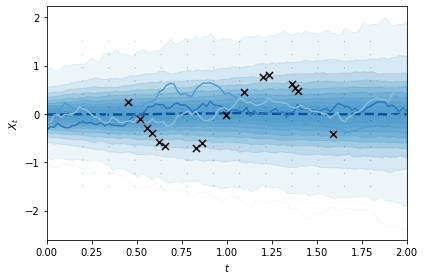

In [9]:
visualize(latent_sde, ts, ys, key=vis_key)

Performing optimization

In [10]:
for iter in range(train_iters):
    # optimizing
    _, sde_key = jrandom.split(sde_key)
    loss, grads = make_step(latent_sde)
    loss = loss.item()
    updates, opt_state = optim.update(grads, opt_state)
    latent_sde = eqx.apply_updates(latent_sde, updates)
    if iter % pause_freq == 0:
        print(f"Iteration {iter} \t Loss: {loss:.3f}")

Iteration 0 	 Loss: 1902.684
Iteration 10 	 Loss: 844.538
Iteration 20 	 Loss: 714.417
Iteration 30 	 Loss: 647.058
Iteration 40 	 Loss: 620.454
Iteration 50 	 Loss: 617.509
Iteration 60 	 Loss: 611.872
Iteration 70 	 Loss: 605.436
Iteration 80 	 Loss: 596.413
Iteration 90 	 Loss: 579.904
Iteration 100 	 Loss: 550.396
Iteration 110 	 Loss: 504.445
Iteration 120 	 Loss: 433.889
Iteration 130 	 Loss: 330.804
Iteration 140 	 Loss: 232.720
Iteration 150 	 Loss: 75.469
Iteration 160 	 Loss: 31.005
Iteration 170 	 Loss: 17.251
Iteration 180 	 Loss: 10.265
Iteration 190 	 Loss: 7.531
Iteration 200 	 Loss: 5.646
Iteration 210 	 Loss: 4.482
Iteration 220 	 Loss: 3.774
Iteration 230 	 Loss: 3.232
Iteration 240 	 Loss: 2.790
Iteration 250 	 Loss: 2.412
Iteration 260 	 Loss: 2.078
Iteration 270 	 Loss: 1.782
Iteration 280 	 Loss: 1.519
Iteration 290 	 Loss: 1.285
Iteration 300 	 Loss: 1.074
Iteration 310 	 Loss: 0.881
Iteration 320 	 Loss: 0.703
Iteration 330 	 Loss: 0.539
Iteration 340 	 Loss: 0.

We obtain the posterior SDE after training

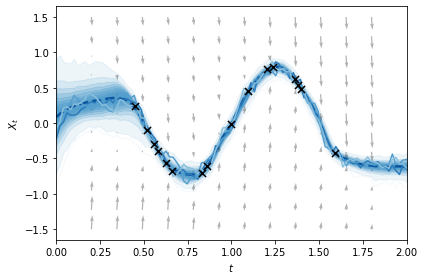

In [11]:
visualize(latent_sde, ts, ys, key=vis_key)